<h1><center>UBC Reddit Analysis </center></h1>

## Introduction:
Reddit is a social media platform where people can discuss, and engage in many different topics (even controversial topics) and people can upvote and downvote on content where they feel appropriate for that specific subreddit. UBC has its own subreddit where students usually engage to ask for advice on how to make their University experience smooth or generally ask for advice and information from their fellow classmates or just a place for UBC students to hang out and talk about things related to the school. Also, the school subreddit can also be a place where people express their negative feeling as the platform is entirely anonymous as opposed to other platforms like Facebook, Twitter, or Instagram. Because of the anonymity, Reddit is the social media platform that UBC students engage the most on as compared to other social media platforms.

As a UBC student, I am always curious about what the environment of the school is like, so Reddit is a good place to do some analysis to know more about my fellow students.
In other words, this project is about scrapping the current data on the University subreddit and analyze to see if we can get any insights on what type of students use the platform and what they usually talk about.


## Technical detail
I will scrape my own data directly from the UBC subreddit using the PushShiftAPI. I attempted to manually use selenium and Beautiful soup to do this or even use the official Reddit API. However, those methods can have their limitation and it takes a lot of time to manually scrap the data, which is why I will stick with the PushShiftAPI. However, even with the PushShiftAPI, there are still many limitations that prevent me from getting the most useful data for my analysis.
(Note: have to Install psaw, requests in order for this to work)

I will try to create and scrape as much useful data as possible using a method like pre-processing text as learned in the "Working with Text" lecture. Also, I try to incorporate some of the code snippets from the lecture to make the data as useful as possible

Sadly, the data that I scraped does not have any quantifiable data like numbers which makes it hard to run any machine learning algorithm. Also, when I use pushShiftAPI, I can not get useful data like the upvote ratio of the post or filter out what kind of post I want to take, or get the user's flair whenever I want to. I can use the official Reddit API to get those data but the Reddit API only lets me query at most 100 posts at a time.

In [2]:
pip install psaw                 #Installing pushshift library


Note: you may need to restart the kernel to use updated packages.


In [2]:
# pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
# pip install requests

Note: you may need to restart the kernel to use updated packages.


In [3]:
from psaw import PushshiftAPI    
import datetime as dt
import matplotlib.pyplot as plt 
import pandas as pd
import nltk
import string
from bs4 import BeautifulSoup

import numpy as np

import requests
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [4]:
api = PushshiftAPI() # Initialize API

# Introduction:

### First step in this project will be collecting and cleaning data 

I use an the PushshiftAPI() to collect data that I want to use. In this case specifically, I will collect the data in the UBC subreddit. Notice how I convert some of the dataFrame into CSV file because the API is not reliable as sometime they work and sometime they do not.

In [5]:
#Note: This is taken from https://medium.com/mcd-unison/using-pushshift-api-for-data-analysis-on-reddit-b08d339c48b8
def data_prep_posts(subreddit, start_time, end_time, filters, limit):
    if(len(filters) == 0):
         filters = ['id', 'author', 'created_utc',
                   'domain', 'url',
                   'title', 'num_comments']                   
                   #We set by default some useful columns

    posts = list(api.search_submissions(
        subreddit=subreddit,   #Subreddit we want to audit
        after=start_time,      #Start date
        before=end_time,       #End date
        filter=filters,        #Column names we want to retrieve
        limit=limit))          ##Max number of posts

    return pd.DataFrame(posts) #Return dataframe for analysis

def data_prep_comments(term, start_time, end_time, filters, limit):
    if (len(filters) == 0):
        filters = ['id', 'author', 'created_utc',
                   'body', 'permalink', 'subreddit']
                   #We set by default some usefull columns 

    comments = list(api.search_comments(
        q=term,                 #Subreddit we want to audit
        after=start_time,       #Start date
        before=end_time,        #End date
        filter=filters,         #Column names we want to retrieve
        limit=limit))           #Max number of comments
    return pd.DataFrame(comments) #Return dataframe for analysis
UBCreddit = "UBC"  

Here, I will get the data (All the post) from January 1st to March 28th. (There is a limitation on how much data I can get so I can not get more than this)

`Note: This code snippet takes a really long time to run as it directly extract the data from reddit and convert it to CSV File` 

In [6]:

filter = []
limit = 1000                 
for i in range(1,4):
    start_time = int(dt.datetime(2022, i, 1).timestamp())  
    end_time = int(dt.datetime(2022, i, 28).timestamp())  
    UBCdata = data_prep_posts(UBCreddit, start_time, end_time,filter, limit)
    # This line is also taken from https://medium.com/mcd-unison/using-pushshift-api-for-data-analysis-on-reddit-b08d339c48b8
    UBCdata['datetime'] = UBCdata['created_utc'].map(
        lambda t: dt.datetime.fromtimestamp(t))
    UBCdata = UBCdata.drop('created_utc', axis=1) 
    #Sort the Row by datetime               
    UBCdata = UBCdata.sort_values(by='datetime')  
    UBCdata.to_csv("data.csv", mode = 'a')

/opt/conda/lib/python3.9/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
/opt/conda/lib/python3.9/site-packages/psaw/PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")


In [7]:
data = pd.read_csv("data.csv", on_bad_lines='skip')
data.drop(["Unnamed: 0"], axis = 1)
filtered_data = data.rename(columns = {"d_" : "dataForUsage"})
UBCtitleContent = filtered_data["title"]
filtered_data.head()

,Unnamed: 0,author,domain,id,num_comments,title,url,created,dataForUsage,datetime
0,997.0,CyberneticTitan,i.imgur.com,s2ho25,0,Some UBC Engineering classes to resume in-pers...,https://i.imgur.com/UpuaHLu.png,1642023417.0,"{'author': 'CyberneticTitan', 'created_utc': 1...",2022-01-12 21:36:57
1,996.0,CyberneticTitan,i.imgur.com,s2hq5e,0,Some UBC Engineering classes to resume in-pers...,https://i.imgur.com/HjZB1Lc.png,1642023573.0,"{'author': 'CyberneticTitan', 'created_utc': 1...",2022-01-12 21:39:33
2,995.0,ubcthrowaway114,self.UBC,s2i5j8,0,2019-2020 was unbeatable,https://www.reddit.com/r/UBC/comments/s2i5j8/2...,1642024682.0,"{'author': 'ubcthrowaway114', 'created_utc': 1...",2022-01-12 21:58:02
3,994.0,sarah_066,i.redd.it,s2ideo,0,Huh.,https://i.redd.it/53prtxwiybb81.jpg,1642025228.0,"{'author': 'sarah_066', 'created_utc': 1642025...",2022-01-12 22:07:08
4,993.0,freddtaco,i.redd.it,s2jb08,0,Allard law is returning to in-person on Jan. 24,https://i.redd.it/ab1cvnos5cb81.jpg,1642027673.0,"{'author': 'freddtaco', 'created_utc': 1642027...",2022-01-12 22:47:53


Here, I will get all the data (comments on every post) from January 1st to March 28th.

In [9]:
limit = 1000
filter = []
flair_text_filter = ["author_flair_text"]
for i in range(1,4):
    start_time = int(dt.datetime(2022, i, 1).timestamp())  
    end_time = int(dt.datetime(2022, i, 28).timestamp())
    data_comment = data_prep_comments(UBCreddit, start_time, end_time, filter, limit)
    flair_collection = data_prep_comments(UBCreddit, start_time, end_time, flair_text_filter, limit)
    data_comment['datetime'] = data_comment['created_utc'].map(
        lambda t: dt.datetime.fromtimestamp(t))
    data_comment.to_csv("comment_data.csv", mode = 'a')

/opt/conda/lib/python3.9/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
/opt/conda/lib/python3.9/site-packages/psaw/PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")


In [8]:
comment_data = pd.read_csv("comment_data.csv",on_bad_lines='skip')
ubc_comment_data = comment_data[comment_data["subreddit"] == 'UBC']
ubc_comment_content = ubc_comment_data["body"]
ubc_comment_data.head()


,Unnamed: 0,author,body,created_utc,id,permalink,subreddit,created,d_,datetime
0,0.0,makeshiftswift,"I know its probably hard to estimate, but does...",1643326986,huie2tv,/r/UBC/comments/o00ufd/ubc_course_question_pro...,UBC,1643326986.0,"{'author': 'makeshiftswift', 'body': ""I know i...",2022-01-27 23:43:06
3,3.0,beans_and_bees_,"I know this is a joke, but my uot hoodie is wa...",1643325666,huiauzs,/r/UBC/comments/sea3y5/what_do_yall_typically_...,UBC,1643325666.0,"{'author': 'beans_and_bees_', 'body': 'I know ...",2022-01-27 23:21:06
4,4.0,AutoModerator,\n[Your submission](https://www.reddit.com/r/U...,1643325581,huiandw,/r/UBC/comments/sebrd1/chemistry_students_or_a...,UBC,1643325581.0,"{'author': 'AutoModerator', 'body': '\n[Your s...",2022-01-27 23:19:41
7,7.0,sunygeorgia,Yes! I play a lot of Phasmo with my friends (s...,1643324395,hui7pbs,/r/UBC/comments/seb2is/anyone_wanna_try_random...,UBC,1643324395.0,"{'author': 'sunygeorgia', 'body': 'Yes! I play...",2022-01-27 22:59:55
12,12.0,RooniltheWazlib,Do yall think it's socially acceptable? What a...,1643322520,hui2wp0,/r/UBC/comments/sea3y5/what_do_yall_typically_...,UBC,1643322520.0,"{'author': 'RooniltheWazlib', 'body': ""Do yall...",2022-01-27 22:28:40


## Use the method learned in "Working with Text" lecture to extract word for good use in the analysis.

I clean the data to get all the most common words in the post and comments and then clean it more by only taking valid words that actually has meaning.

In [9]:
## 1. Clean data
# Remove stopwords (the, a, is, etc)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
## 3. Remove stopwords
stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords=stopwords.union(set(string.punctuation))
# 4.Lemmatize words e.g. snowed and snowing are both snow (verb)
wnl = nltk.WordNetLemmatizer()


[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jupyter/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [10]:
## This code snippet is taken from lecture.
def text_prep(txt):
    txt = txt.lower()
    tokens = [token for token in nltk.tokenize.word_tokenize(txt)]
    tokens = [token for token in tokens if not token in stopwords]
    #tokens = [token for token in tokens if not token ]
    tokens = [wnl.lemmatize(token) for token in tokens]
    if (len(tokens)==0):
        tokens = ["EMPTYSTRING"]
    return(tokens)

## This code snippet is mine.
listofTitle = []
listofComment = []
for title in UBCtitleContent:
    listofTitle.append(text_prep(title))
    

for comment in ubc_comment_content:
    listofComment.append(text_prep(comment))
TotalwordFrequencyInTitle = nltk.FreqDist([word for doc in listofTitle for word in doc]).most_common(100)
TotalwordFrequencyInComment = nltk.FreqDist([word for doc in listofComment for word in doc]).most_common(5000)
wordFrequencyInTitle = []
for word in TotalwordFrequencyInTitle:
    if len(word[0]) >= 3:
        wordFrequencyInTitle.append(word)


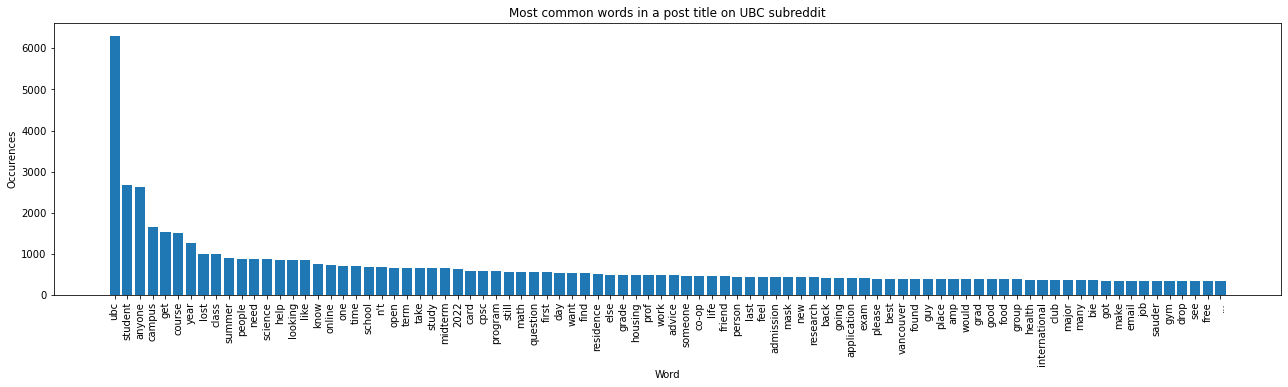

In [11]:
## This code snippet is taken from lecture.
wordFrequencyInTitle
words = [x[0] for x in wordFrequencyInTitle]
cnt = [x[1] for x in wordFrequencyInTitle]

fig, ax = plt.subplots(figsize=(22,5))
ax.bar(range(len(words)), cnt);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Most common words in a post title on UBC subreddit');
ax.set_xlabel('Word');
ax.set_ylabel('Occurences');
plt.show()


## Question: What do UBC students usually discuss about on reddit and who post these?

As can be seen from the above diagram which illustrates the most common words that UBC students use on their title for a Reddit submission, UBC students tend to discuss a lot of things :)
1. The most obvious category that probably everyone expects is that they usually discuss the school itself which can be inferred from "ubc" or just typical college life concerns like courses, major, midterm, exam, grade,... People in this category are probably the student who are currently enrolling in the school
2. Also there are many posts that concern about career or graduate school which can be inferred from post that has words like "co-op", "job", "research", "admission"

3. Interestingly, I assume that students who major in Computer Science are most likely to be active on UBC Reddit as can be seen from those data, "cpsc" (Computer Science) is the major that has the most occurrence in the entire data set. You might also ask what about math and science? Math is a subject students from many disciplines can take so it is the subject that is more likely to be discussed. For example, an Econ student has to take math courses as well as students in other disciplines like engineering or even forestry and food science major. Also, science is an entire faculty and many other majors can have the word science in it like computer science, environmental science.

## Let's answer the question, student in which major use reddit the most?

Here, I try to extract a small random sample of data to observe students in which major use Reddit the most. (Note: this data is entirely random) and I can not extract all of the data because of the API limitation that restricts me from getting the user flair (in this case the student's major) when I exceed a certain amount of queries.

In [12]:
start_time = int(dt.datetime(2021, 1, 1).timestamp())  
end_time = int(dt.datetime(2022, 3, 30).timestamp())  
new_comment_data = api.search_comments(q = "sad", subreddit = "UBC", after = start_time, before = end_time)
frame = pd.DataFrame(new_comment_data)


In [13]:
listOfFlair = {}
for flair in frame["author_flair_template_id"]:
    if len(str(flair)) < 30 and str(flair) != "None":
        if str(flair) not in listOfFlair:
            listOfFlair[str(flair)] = 1
        else:
            listOfFlair[str(flair)] += 1
            

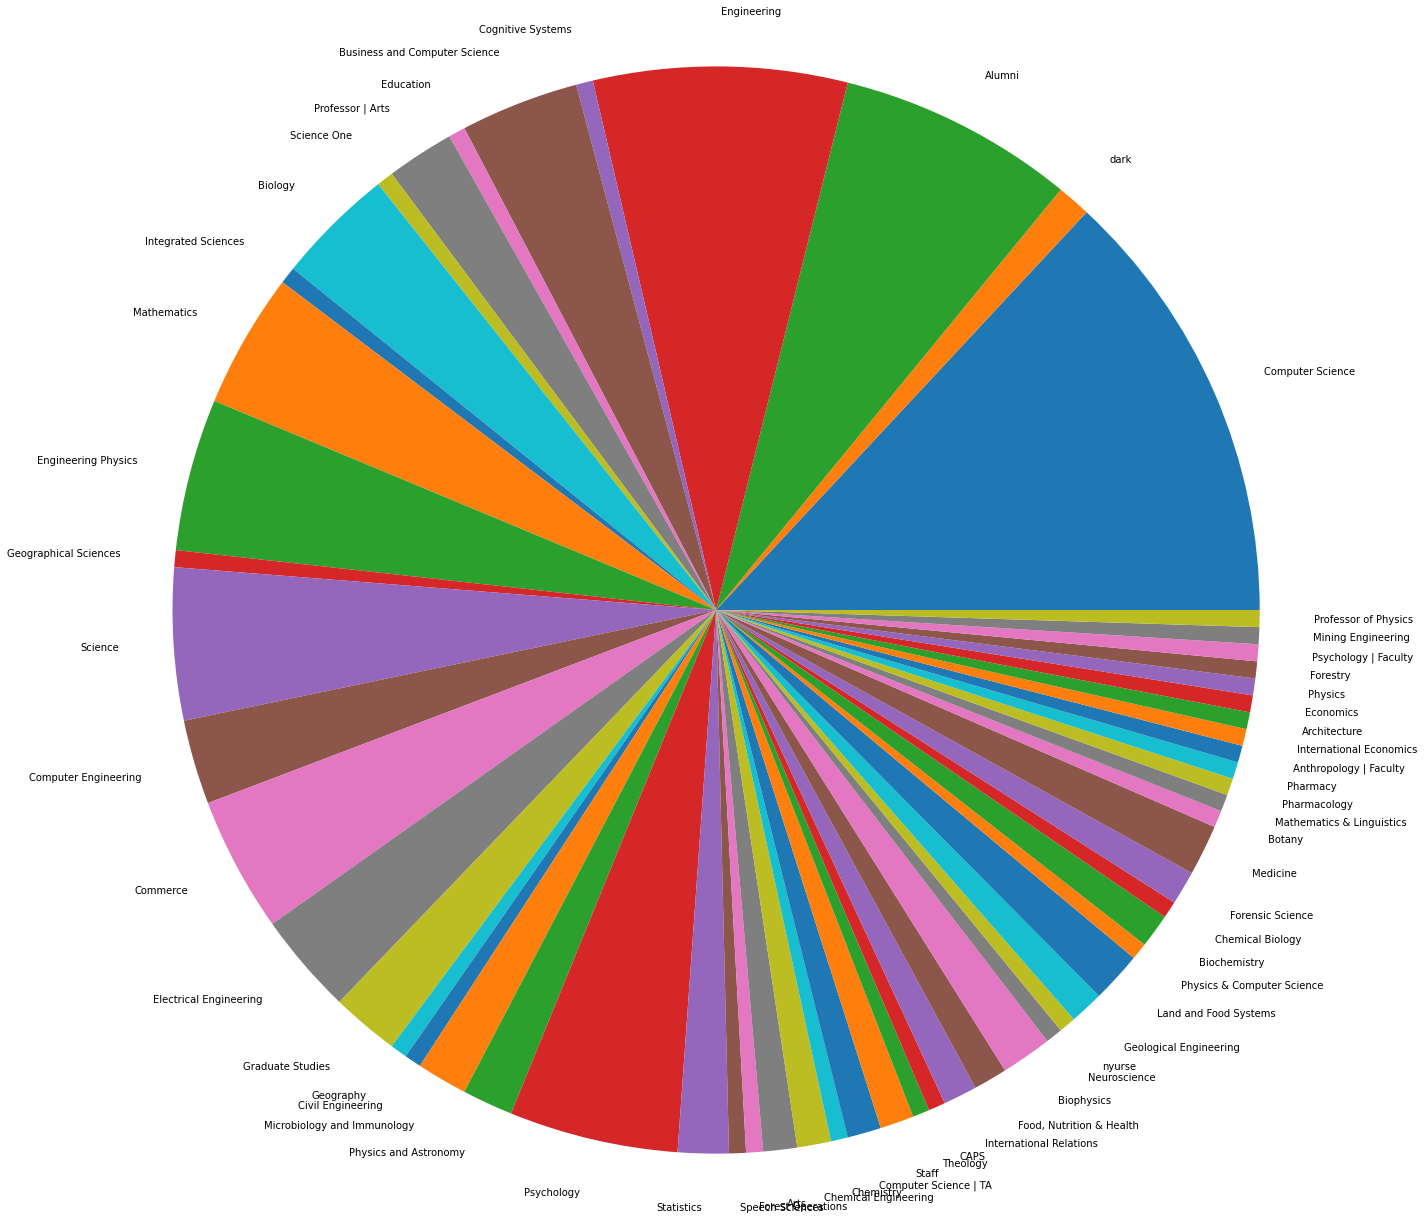

In [14]:
major = list(listOfFlair.keys())
quantity = list(listOfFlair.values())
fig, ax = plt.subplots(figsize=(34,5))
plt.pie(quantity, labels = major, radius = 5)
plt.show()

Some Observation:
- As can be observed from the above graph, students who major in Computer Science or have another major combined with Computer Science (eg. Business and Computer Science, Physics & Computer Science) are most likely to use this platform compare to other majors, which confirms my hypothesis that I made above. 
- Another interesting observation from the above chart is that students who use Reddit are more likely to be a STEM(Science, Technology, Engineer, and Math) major.
- Interestingly, Economics major does not have their presence as much as other major as they are just a small minority in the above chart 
- One other thing is that not only current student who has their presence on the platform but also Professor, Alumni, and Faculty also has a presence on the platform
- Note: Again, this is just a sample dataset that is scrapped randomly out of nowhere in the comments section so this might not be entirely accurate.

## Let's do some more analysis to determine what kind of discussions or comments student usually has on the subreddit

+ As can be observed from the most common words in the post title, there are many types of discussions that students may have which can be categorized as follows:
    - About life at UBC and just something related to the school in general
    - Typical college life concerns like grades, midterm/final, major selection
    - Career-related things like jobs, internships, graduate school
    - Comments that are somewhat sad to read because it involves mental health.


Let's categorize those 4 category into 4 list and see which type of conversation student usually has in the comment section

In [15]:
UBCrelatedComments = ['ubc', 'campus', 'school', 'university', 'faculty']
typicalCollegeLife = ['midterm', 'final', 'gpa', 'major', 'grade', 'cpsc', 'math', 'economic','engineer', 'midterm/final', 'pre-requisites']
careerRelated = ['co-op', 'internship','pre-med', 'graduate','job', 'application', 'competitive', 'entrepreneurial', 'employer', 'employee', 'experience']
mentalHealthRelated = ['sad', 'life', 'depressed', 'lonely', 'suck', 'lost', 'rejected', 'fail', 'overwhelming','mental','health','pain','guilty', 'emotional','debt', 'pandemic']
UBCscore = 0
CollegeLifeScore = 0
careerScore = 0
mentalHealthScore = 0
# for comment in listofComment:
#     if isinstance(comment, list):
#         for smallerComment in comment:
#             if small
FrequencyOfComment = []
for comment in TotalwordFrequencyInComment:
    if len(comment[0]) > 2 and not isinstance(comment[0], int) and not isinstance(comment[0], float):
        FrequencyOfComment.append(comment)
for comment in FrequencyOfComment:
    if comment[0] in UBCrelatedComments:
        UBCscore += comment[1]
    if comment[0] in typicalCollegeLife:
        CollegeLifeScore += comment[1]
    if comment[0] in careerRelated:
        careerScore += comment[1]
    if comment[0] in mentalHealthRelated:
        mentalHealthScore += comment[1]

I categorized the group of comments into 4 groups. The first group which is ubcrelatedComment group is the group that has comments related to the school itself which consists of comment that has words like UBC, campus,... The second group is the typicalCollegeLife group where student comments on their day-to-day things like midterm, GPA, major,... The third group is the group that talks about stuff that is related to graduate school and career things. The last group is groups that talk about mental health-related stuff.


Text(0.5, 1.0, 'Kind of discussion/comments UBC student has on the subreddit')

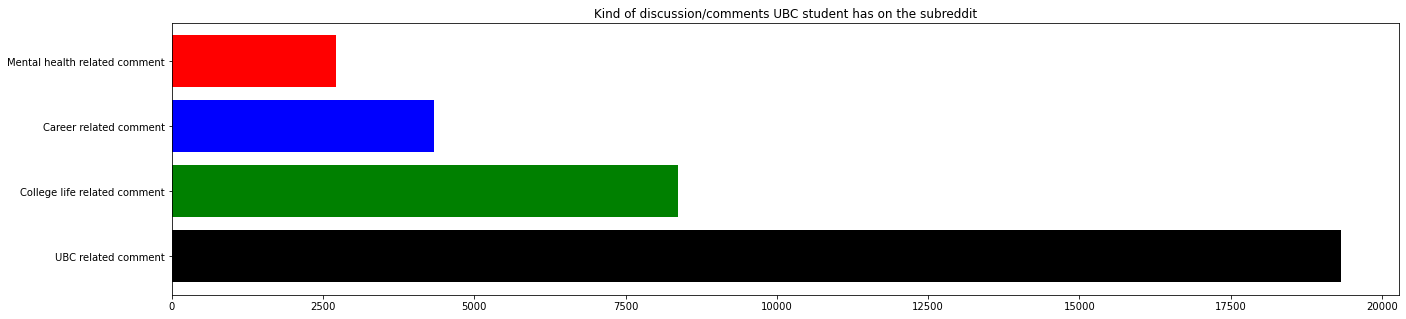

In [16]:
plottingData = [UBCscore, CollegeLifeScore, careerScore, mentalHealthScore]
Categories = ("UBC related comment", "College life related comment","Career related comment", "Mental health related comment")
x_pos = np.arange(len(Categories))
fig, ax = plt.subplots(figsize=(22,5))
plt.barh(x_pos, plottingData, color=['black', 'green', 'blue', 'red'])
plt.yticks(x_pos, Categories)
plt.title("Kind of discussion/comments UBC student has on the subreddit")

-As can be seen from the above graph, UBC student tends to discuss most comment and discussion related to UBC. Moreover, college-related comments have the second most comments compared to other types of comments. Unfortunately, many students have comments related to mental health which is sad to see :(. One positive thing about the above graph is that students also tend to talk about career-related stuff which is very encouraging.

## Let's explore the career-related section. I want to know what majors talk about internship-related stuff and which majors talk about pursuing graduate school and doing research.

Again, I will extract data from the subreddit and clean it as much as possible. (Some of the code snippets takes a long time to run)

In [26]:
start_time = int(dt.datetime(2020, 12, 1).timestamp())  
end_time = int(dt.datetime(2022, 3, 30).timestamp())  
flair_text_filter = ["author_flair_text"]
internship = api.search_comments(q = "internship", subreddit = "UBC", after = start_time, before = end_time, filter = flair_text_filter)
internshipFrame = pd.DataFrame(internship)

`What I am doing here is basically finding all the comments on Reddit that has the keyword "internship", and extract the flair (major) of the person who comment that. I will repeat this same process for other words like coop, research, grad school`

In [18]:
coop = api.search_comments(q = "coop", subreddit = "UBC", after = start_time, before = end_time, filter = flair_text_filter)
coopFrame = pd.DataFrame(coop)

/opt/conda/lib/python3.9/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
/opt/conda/lib/python3.9/site-packages/psaw/PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")


In [19]:
def extractingMajor(dataFrame, majorWithItsAssociatedNumber):
    for flair in dataFrame["author_flair_text"]:
        if str(flair) != "None":
            if str(flair) not in majorWithItsAssociatedNumber:
                majorWithItsAssociatedNumber[str(flair)] = 1
            else:
                majorWithItsAssociatedNumber[str(flair)] += 1

In [20]:
majorwithInternshipAndCoop = {}
extractingMajor(internshipFrame, majorwithInternshipAndCoop)
extractingMajor(coopFrame, majorwithInternshipAndCoop)
## This line is from stackOverFlow. It essentially sort 
the dictionary by value
majorwithInternshipAndCoop = sorted(majorwithInternshipAndCoop.items(), key = lambda kv: kv[1])
majorwithInternshipAndCoop = dict(majorwithInternshipAndCoop)

In [21]:
gradschool = api.search_comments(q = "grad school", subreddit = "UBC", after = start_time, before = end_time, filter = flair_text_filter)
gradschoolFrame = pd.DataFrame(gradschool)

In [22]:
research = api.search_comments(q = "research", subreddit = "UBC", after = start_time, before = end_time, filter = flair_text_filter)
researchFrame = pd.DataFrame(research)

In [23]:
majorWithResearchAndGradSchool = {}
extractingMajor(researchFrame, majorWithResearchAndGradSchool)
extractingMajor(gradschoolFrame, majorWithResearchAndGradSchool)
majorWithResearchAndGradSchool = sorted(majorWithResearchAndGradSchool.items(), key = lambda kv: kv[1])
majorWithResearchAndGradSchool = dict(majorWithResearchAndGradSchool)

## What majors are most likely to talk about internship and finding jobs?

As can be observed from the graph, Computer Science, Electrical Engineering, Engineering Physics, Business (Commerce)  and Biochemistry are the majors that have the most people talk about internships. Computer Science major dominates other majors but we must also account for the fact that Computer Science has the most presence in this subreddit as we discovered earlier. Also, some Alumni might be giving advice to undergraduate students about internship related stuff.

 ## What major are most likely to talk about graduate school and research?

Text(0.5, 1.0, 'Top major that talks about research and graduate school')

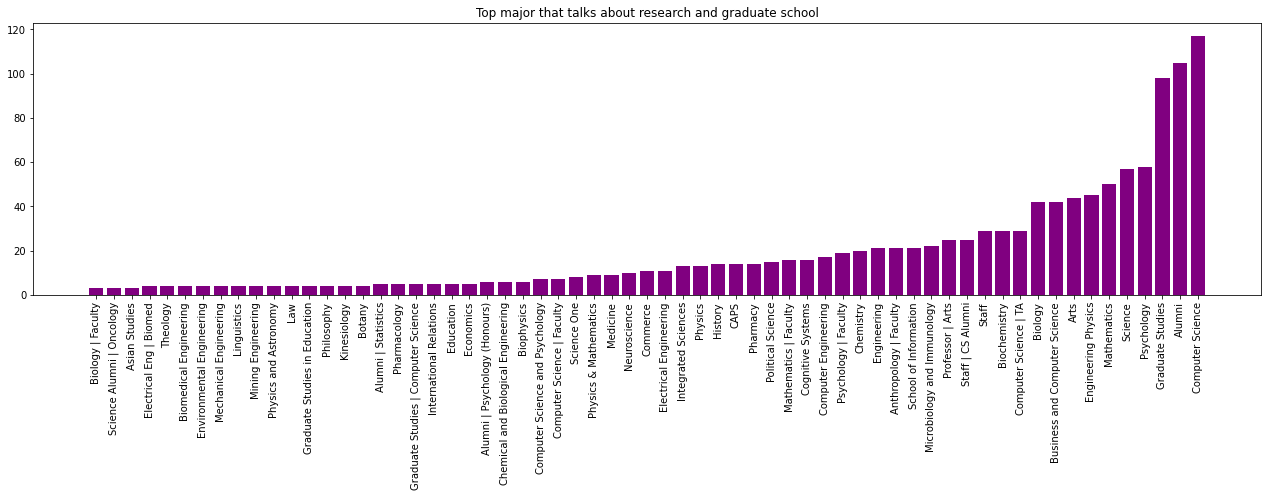

In [25]:
majorWithResearch = list(majorWithResearchAndGradSchool.keys())[60:]
ResearchQuantity = list(majorWithResearchAndGradSchool.values())[60:]
researchPlottingFrame = pd.DataFrame({"major": majorWithResearch, "Number of Comment" : ResearchQuantity})
plt.subplots(figsize=(22,5))
plt.xticks(rotation='vertical')
plt.bar(majorWithResearch, ResearchQuantity, color = "purple")
plt.title("Top major that talks about research and graduate school")

We still see majors like Computer Science and Engineering Physic also talk about research. However, one big difference in this graph compare to the above is that we see the presence of "Psychology" major and people in "Graduate Studies". This makes totally make sense because Psychology major are usually into research and graduate school . Mathematics and Biology also have a strong presence when it comes to discussion related to grad school and research.Again, the dominant of Computer Science is not likely to be accurate as they are the majority in every discussion on Reddit. Another bonus point, we now see Economics major on the graph :) I think that Economics major lean more towards pursuing grad school and doing research as opposed to finding jobs earlier on like engineering and Computer Science.

## Conclusion:
I found it very interesting how just by extracting many small pieces of data from the school subreddit, I can gain some insight into more about the community of the school. The analysis could have been better if I know how to get some of the more useful data on Reddit like the number of comments, upvotes, and downvote ratio.